<a href="https://colab.research.google.com/github/denyip/yolov5_object_detect/blob/main/01_youtube_yolo_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.coderbridge.com/series/c471d97bb201460ab137c5e4955987df/posts/0baeb8bf25e543ed8462bd742cd1946f

In [34]:
!pip install pytube

In [35]:
import os
import subprocess
from pytube import YouTube
import torch
import numpy as np
import cv2
from time import time

In [36]:
print('torch %s %s' %(torch.__version__,torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

torch 1.10.0+cu111 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [37]:
ffprobe_path = '/usr/bin/ffprobe'
ffmpeg_path = '/usr/bin/ffmpeg'
# video_url = 'https://youtu.be/9bZkp7q19f0'
# video_url = 'http://youtube.com/watch?v=2lAe1cqCOXo'
video_url = 'https://www.youtube.com/watch?v=NLGANuF3cgw'

In [38]:
# 檢查影片檔是否包含聲音
fileobj = {}
download_count = 1
def check_media(filename):
    r = subprocess.Popen([ffmpeg_path, filename],
                         stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    out, err = r.communicate()

    if (out.decode('utf-8').find('Audio') == -1):
        return -1  # 沒有聲音
    else:
        return 1
# 合併影片檔
def merge_media():
    temp_video = os.path.join(fileobj['dir'], 'temp_video.mp4')
    temp_audio = os.path.join(fileobj['dir'], 'temp_audio.mp4')
    temp_output = os.path.join(fileobj['dir'], 'output.mp4')

    cmd = f'"{ffmpeg_path}" -i "{temp_video}" -i "{temp_audio}" \
        -map 0:v -map 1:a -c copy -y "{temp_output}"'
    try:
        subprocess.call(cmd, shell=True)
        # 視訊檔重新命名
        os.rename(temp_output, os.path.join(fileobj['dir'], fileobj['name']))
        os.remove(temp_audio)
        os.remove(temp_video)
        print('視訊和聲音合併完成')
    except:
        print('視訊和聲音合併失敗')

def download_sound():
    try:
        yt.streams.filter(type="audio").first().download()
    except:
        print('下載影片時發生錯誤，請確認網路連線和YouTube網址無誤。')
        return

def onProgress(stream, chunk, remains):   
    total = stream.filesize
    percent = (total-remains) / total * 100
    print('下載中… {:05.2f}%'.format(percent), end='\r')


# 檔案下載的回呼函式
def onComplete(stream, file_path):
    global download_count, fileobj
    fileobj['name'] = os.path.basename(file_path)
    fileobj['dir'] = os.path.dirname(file_path)
    fileobj['full_path'] = file_path
    
    if download_count == 1:
        if check_media(file_path) == -1:
            print('此影片沒有聲音')
            download_count += 1
            try:
                # 視訊檔重新命名
                os.rename(file_path, os.path.join(
                    fileobj['dir'], 'temp_video.mp4'))
            except:
                print('視訊檔重新命名失敗')
                return

            print('準備下載聲音檔')
            download_sound()          # 下載聲音
        else:
            print('此影片有聲音，下載完畢！')
    else:
        try:
            # 聲音檔重新命名
            os.rename(file_path, os.path.join(
                fileobj['dir'], 'temp_audio.mp4'))
        except:
            print("聲音檔重新命名失敗")
        # 合併聲音檔
        merge_media()

In [39]:
yt = YouTube(video_url, on_progress_callback=onProgress,
                     on_complete_callback=onComplete)
yt.streams.filter(subtype='mp4',resolution='1080p')[0].download()

此影片沒有聲音
準備下載聲音檔
視訊和聲音合併完成


'/content/Hong Kong Street Food Tour in Whampoa Go local and Off the Eaten Path!.mp4'

In [40]:
def get_video_duration(filename):
    video = cv2.VideoCapture(filename)
    fps = video.get(cv2.CAP_PROP_FPS)
    frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)
    seconds = frame_count / fps
    minutes = int(seconds / 60)
    rem_sec = int(seconds % 60)
    return f"fps: {fps} duration: {minutes}:{rem_sec}"

In [41]:
print(get_video_duration(fileobj['full_path']))

fps: 25.0 duration: 0:39


In [47]:
import json

class ObjectDetection:
  """
  Class implements Yolo5 model to make inferences on a youtube video using Opencv2.
  """
  
  def __init__(self, url, conf_level=0.3):
    """
    Initializes the class with youtube url and output file.
    :param url: Has to be as youtube URL,on which prediction is made.
    :param out_file: A valid output file name.
    """
    self._URL = url
    self.model = self.load_model()
    self.classes = self.model.names   
    self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    self.conf_level = conf_level
    self.filename = os.path.basename(self._URL)
    
  def load_model(self):
    """
    Loads Yolo5 model from pytorch hub.
    :return: Trained Pytorch model.
    """
    model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
    return model

  def score_frame(self, frame):
    """
    Takes a single frame as input, and scores the frame using yolo5 model.
    :param frame: input frame in numpy/list/tuple format.
    :return: Labels and Coordinates of objects detected by model in the frame.
    """
    self.model.to(self.device)
    frame = [frame]
    results = self.model(frame)
    detected_labels, detected_cords = results.xyxyn[0][:, -1].cpu().numpy(), results.xyxyn[0][:, :-1].cpu().numpy()        
    return detected_labels, detected_cords

  def class_to_label(self, x):
    """
    For a given label value, return corresponding string label.
    :param x: numeric label
    :return: corresponding string label
    """
    return self.classes[int(x)]

  def plot_boxes(self, results, frame):
    """
    Takes a frame and its results as input, and plots the bounding boxes and label on to the frame.
    :param results: contains labels and coordinates predicted by model on the given frame.
    :param frame: Frame which has been scored.
    :return: Frame with bounding boxes and labels ploted on it.
    """
    detected_labels, detected_cords = results
    n = len(detected_labels)
    x_shape, y_shape = frame.shape[1], frame.shape[0]
    result_list = []
    for i in range(n):
      row = detected_cords[i]
      if row[4] >= self.conf_level:            
        x1, y1, x2, y2 = int(row[0]*x_shape), int(row[1]*y_shape), int(row[2]*x_shape), int(row[3]*y_shape)
        bgr = (0, 255, 0)
        cv2.rectangle(frame, (x1, y1), (x2, y2), bgr, 2)
        cv2.putText(frame, self.class_to_label(detected_labels[i])+str(round(row[4],2)), (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.9, bgr, 2)
        result_dict = {
            "class_no": str(detected_labels[i]),
            "class_name": self.class_to_label(detected_labels[i]),
            "bbox" :[
                     x1,
                     y1,
                     x2,
                     y2                     
            ],
            "conf_level": str(row[4])
        }
        result_list.append(result_dict)
    return frame,result_list

  def __call__(self):
    out_video_filename = 'out_'+os.path.splitext(self.filename)[0]+'.avi'    
    video = cv2.VideoCapture(self._URL)
    assert video.isOpened()
    frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = video.get(cv2.CAP_PROP_FPS)
    four_cc = cv2.VideoWriter_fourcc(*"MJPG")    
    # out_video_file = cv2.VideoWriter(out_video_filename, four_cc, 20, (frame_width, frame_height))
    out_video_file = cv2.VideoWriter(out_video_filename, four_cc, fps, (frame_width, frame_height))
    out_json = {
                "filename":self.filename,
                "results":[]
                }

    # while video.get(cv2.CAP_PROP_POS_FRAMES) < 10:
    while video.get(cv2.CAP_PROP_POS_FRAMES) < frame_count:
      ret, frame = video.read()
      frame_ts = round(video.get(cv2.CAP_PROP_POS_MSEC)/1000,2)
      frame_pos = int(video.get(cv2.CAP_PROP_POS_FRAMES))
      result = self.score_frame(frame)
      output_frame, result_list = self.plot_boxes(result, frame)          
      # print(f"{frame_pos}:{frame_ts}")
      out_video_file.write(output_frame)
      result_dict = {
          "ts": str(frame_ts),
          "frame_no": str(frame_pos),
          "results": result_list
      }
      out_json["results"].append(result_dict)
    video.release()    
    with open('result.json', 'w') as f:
      json.dump(out_json, f)

In [48]:
a = ObjectDetection(fileobj['full_path'])
a()

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-1-11 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


{'filename': 'Hong Kong Street Food Tour in Whampoa Go local and Off the Eaten Path!.mp4', 'results': [{'ts': '0.0', 'frame_no': '1', 'results': [{'class_no': '76.0', 'class_name': 'scissors', 'bbox': [1326, 386, 1491, 574], 'conf_level': '0.47164762'}]}, {'ts': '0.04', 'frame_no': '2', 'results': [{'class_no': '76.0', 'class_name': 'scissors', 'bbox': [1327, 386, 1487, 572], 'conf_level': '0.5949513'}, {'class_no': '2.0', 'class_name': 'car', 'bbox': [663, 190, 816, 348], 'conf_level': '0.403424'}]}, {'ts': '0.08', 'frame_no': '3', 'results': []}, {'ts': '0.12', 'frame_no': '4', 'results': [{'class_no': '0.0', 'class_name': 'person', 'bbox': [1677, 699, 1728, 847], 'conf_level': '0.667613'}, {'class_no': '5.0', 'class_name': 'bus', 'bbox': [1809, 301, 1919, 772], 'conf_level': '0.563924'}, {'class_no': '0.0', 'class_name': 'person', 'bbox': [284, 785, 334, 905], 'conf_level': '0.52856404'}, {'class_no': '25.0', 'class_name': 'umbrella', 'bbox': [1720, 624, 1802, 655], 'conf_level': '0

In [49]:
!ffmpeg -y -i 'out_Hong Kong Street Food Tour in Whampoa Go local and Off the Eaten Path!'.avi Labeled_Video.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [14]:
from IPython.display import HTML
from base64 import b64encode
 
def show_video(video_path, video_width = 600):
   
  video_file = open(video_path, "r+b").read()
 
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")
 
show_video('/content/Labeled_Video.mp4')

In [50]:
print(get_video_duration('out_Hong Kong Street Food Tour in Whampoa Go local and Off the Eaten Path!.avi'))

fps: 25.0 duration: 0:39


fps: 25.0 duration: 0:39


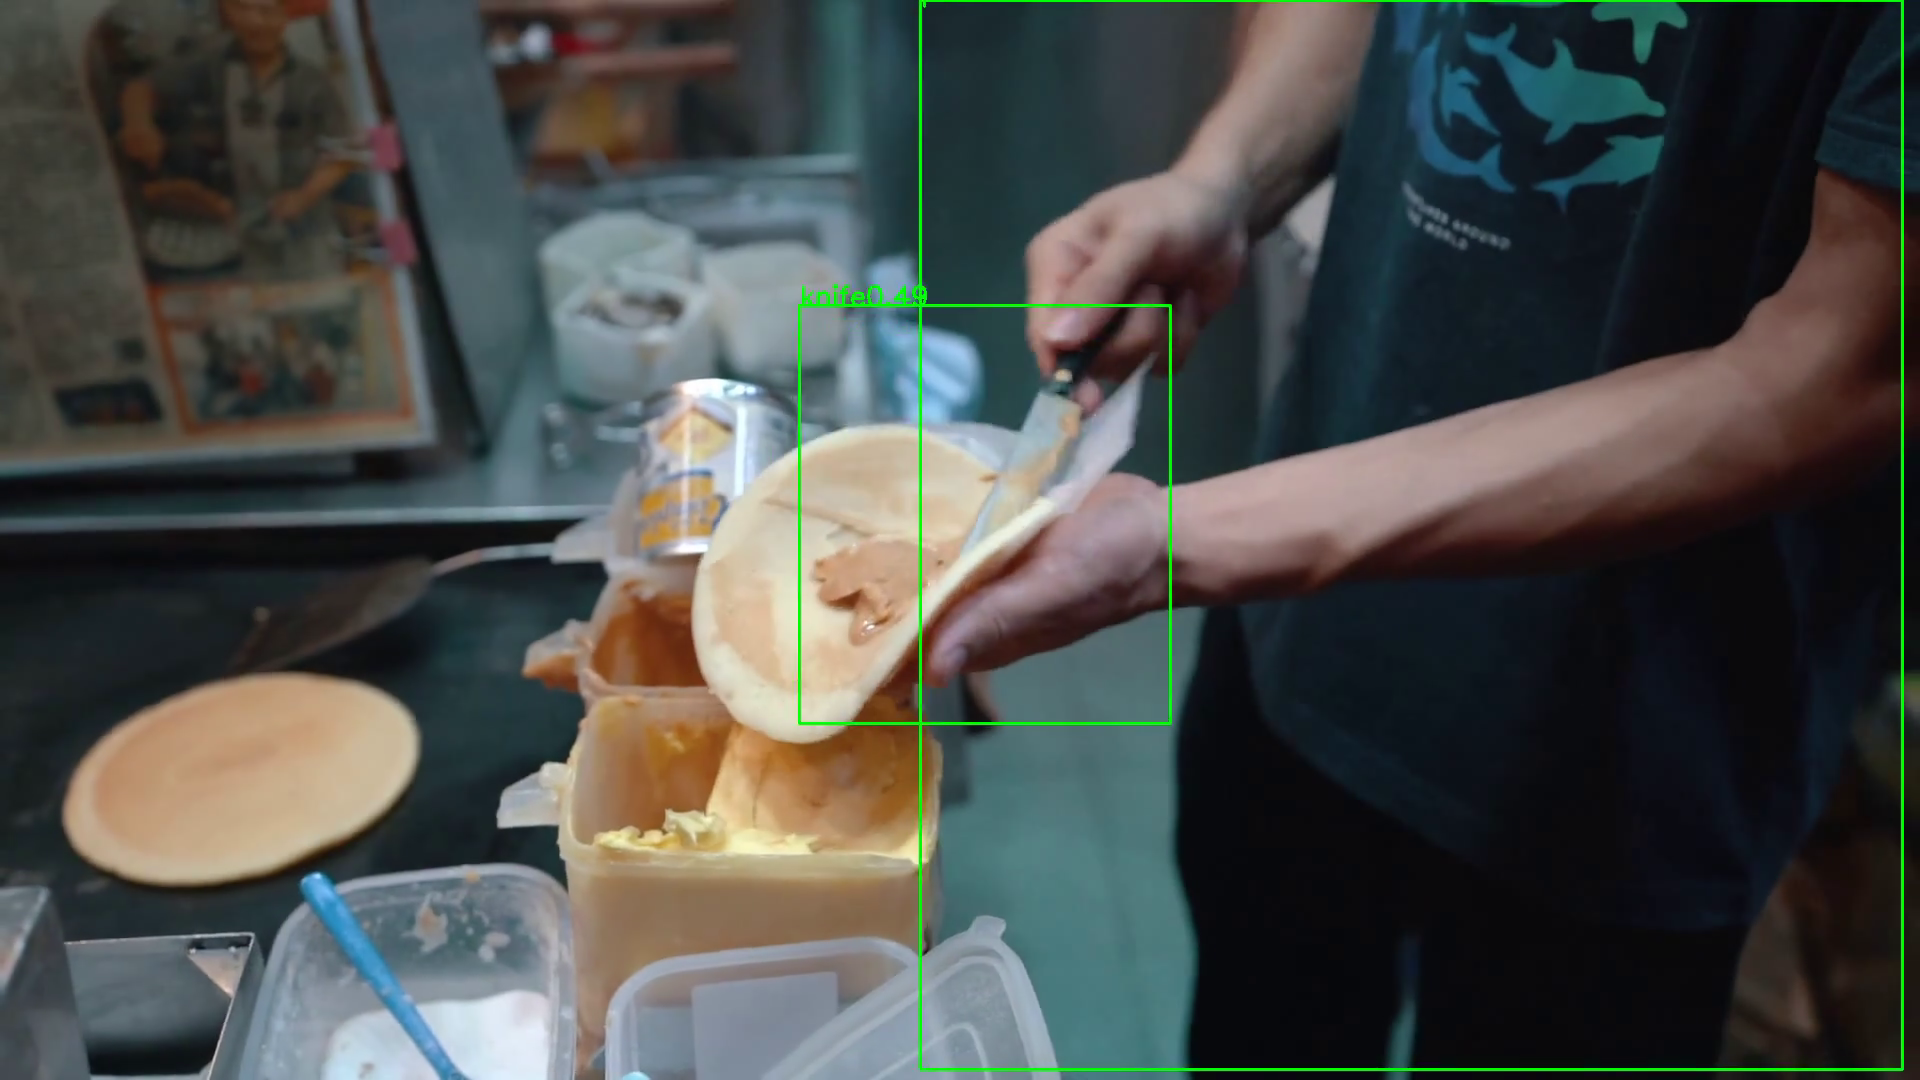

In [51]:
from google.colab.patches import cv2_imshow
cap = cv2.VideoCapture('Labeled_Video.mp4')
print(get_video_duration('Labeled_Video.mp4'))
cap.set(1,641); # Where frame_no is the frame you want
ret, frame = cap.read() # Read the frame
cv2_imshow(frame) # show frame on window